### Loading data

In [27]:
# Loading necessary modules
import pandas as pd
from wordcloud import STOPWORDS, WordCloud
from gensim.models import CoherenceModel
from gensim import corpora
from pprint import pprint
import string
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /home/doit/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [28]:
# Read csv in to data
tweet_data = pd.read_csv('processed_tweet_data.csv')

In [29]:
# print top 5 rows
tweet_data.head()

,created_at,source,original_text,polarity,subjectivity,lang,favorite_count,retweet_count,original_author,followers_count,friends_count,possibly_sensitive,hashtags,user_mentions,place
0,Fri Jun 18 17:55:49 +0000 2021,"<a href=""http://twitter.com/download/iphone"" r...","🚨Africa is ""in the midst of a full-blown third...",0.166667,0.188889,en,548,612,ketuesriche,551,351,NaN,[],"[{'screen_name': 'TelGlobalHealth', 'name': 'T...",Mass
1,Fri Jun 18 17:55:59 +0000 2021,"<a href=""https://mobile.twitter.com"" rel=""nofo...","Dr Moeti is head of WHO in Africa, and one of ...",0.133333,0.455556,en,195,92,Grid1949,66,92,NaN,[],"[{'screen_name': 'globalhlthtwit', 'name': 'An...","Edinburgh, Scotland"
2,Fri Jun 18 17:56:07 +0000 2021,"<a href=""http://twitter.com/download/iphone"" r...",Thank you @research2note for creating this ama...,0.316667,0.483333,en,2,1,LeeTomlinson8,1195,1176,NaN,"[{'text': 'red4research', 'indices': [103, 116]}]","[{'screen_name': 'NHSRDForum', 'name': 'NHS R&...",NaN
3,Fri Jun 18 17:56:10 +0000 2021,"<a href=""https://mobile.twitter.com"" rel=""nofo...","Former Pfizer VP and Virologist, Dr. Michael Y...",0.086111,0.197222,en,1580,899,RIPNY08,2666,2704,NaN,[],"[{'screen_name': 'HighWireTalk', 'name': 'The ...",NaN
4,Fri Jun 18 17:56:20 +0000 2021,"<a href=""http://twitter.com/download/android"" ...",I think it’s important that we don’t sell COVA...,0.280000,0.620000,en,72,20,pash22,28250,30819,NaN,[],"[{'screen_name': 'PeterHotez', 'name': 'Prof P...",United Kingdom


### Data cleaning

* Since the goal of this analysis is to perform topic modeling, let's focus only on the text data and polarity.

In [30]:
# select only 'original_text' and 'polarity' columns
tweet_data = tweet_data[['original_text', 'polarity']]
tweet_data.head()

,original_text,polarity
0,"🚨Africa is ""in the midst of a full-blown third...",0.166667
1,"Dr Moeti is head of WHO in Africa, and one of ...",0.133333
2,Thank you @research2note for creating this ama...,0.316667
3,"Former Pfizer VP and Virologist, Dr. Michael Y...",0.086111
4,I think it’s important that we don’t sell COVA...,0.280000


In [31]:
# text Preprocessing
tweet_data['original_text']=tweet_data['original_text'].astype(str)

# Convert to lowercase
tweet_data['original_text'] = tweet_data['original_text'].map(lambda x: x.lower())

# Remove punctuation
tweet_data['original_text']= \
tweet_data['original_text'].apply(lambda x: x.translate(str.maketrans(' ', ' ', string.punctuation)))

In [32]:
tweet_data.head()

,original_text,polarity
0,🚨africa is in the midst of a fullblown third w...,0.166667
1,dr moeti is head of who in africa and one of t...,0.133333
2,thank you research2note for creating this amaz...,0.316667
3,former pfizer vp and virologist dr michael yea...,0.086111
4,i think it’s important that we don’t sell cova...,0.280000


### Exploratory analysis
* To verify whether the preprocessing, we’ll make a simple word cloud using the `wordcloud` package to get a visual representation of most common words.

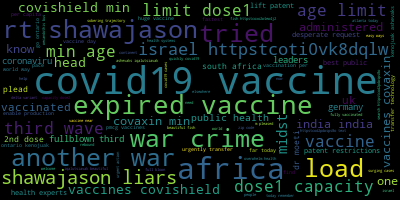

In [33]:
# Join the different processed titles together.
long_string = ','.join(list(tweet_data['original_text'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="black", max_words=800, contour_width=8, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

### Preparing data for LDA analysis
* Next, let’s work to transform the textual data in a format that will serve as an input for training LDA model. We start by tokenizing the text and removing stopwords. Next, we convert the tokenized object into a corpus and dictionary.

In [34]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True)) # deacc=True removes punctuations

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]


data = tweet_data.original_text.values.tolist()
data_words = list(sent_to_words(data))

# remove stop words
data_words = remove_stopwords(data_words)

print(data_words[:1][0][:30])

['africa', 'midst', 'fullblown', 'third', 'wave', 'coronavirus', 'head', 'whoafro', 'warned', 'cases', 'risen', 'across', 'continent', 'deaths', 'also', 'risen', 'last', 'week', 'jriggers', 'reports']


In [35]:
# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 2), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1)]


### LDA model training
* To keep things simple, we'll keep all the parameters to default except for inputting the number of topics. For this tutorial, we will build a model with 10 topics where each topic is a combination of keywords, and each keyword contributes a certain weightage to the topic.

In [36]:
# number of topics
num_topics = 10

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.035*"covid" + 0.018*"africa" + 0.016*"health" + 0.016*"vaccines" + '
  '0.015*"cases" + 0.015*"wave" + 0.015*"india" + 0.015*"third" + '
  '0.014*"midst" + 0.014*"surging"'),
 (1,
  '0.042*"africa" + 0.020*"vaccines" + 0.016*"health" + 0.015*"covid" + '
  '0.013*"know" + 0.013*"public" + 0.012*"lift" + 0.012*"one" + 0.012*"uk" + '
  '0.012*"urgently"'),
 (2,
  '0.040*"covid" + 0.036*"vaccines" + 0.007*"hodkinson" + 0.006*"roger" + '
  '0.006*"vaccine" + 0.006*"amp" + 0.006*"africa" + 0.005*"one" + '
  '0.005*"government" + 0.005*"hospital"'),
 (3,
  '0.035*"covid" + 0.023*"vaccines" + 0.015*"doses" + 0.014*"vaccine" + '
  '0.012*"africa" + 0.010*"amp" + 0.009*"million" + 0.008*"dose" + '
  '0.008*"risk" + 0.007*"cases"'),
 (4,
  '0.053*"vaccines" + 0.035*"covid" + 0.026*"israel" + 0.022*"rt" + '
  '0.021*"expired" + 0.020*"another" + 0.019*"crime" + 0.019*"load" + '
  '0.019*"war" + 0.019*"tried"'),
 (5,
  '0.038*"vaccines" + 0.025*"covid" + 0.023*"dose" + 0.018*"capacity" + 

### Analyzing LDA model results
* Now that we have a trained model let’s visualize the topics for interpretability. To do so, we’ll use a popular visualization package, pyLDAvis which is designed to help interactively with:

1. Better understanding and interpreting individual topics, and
2. Better understanding the relationships between the topics.

In [37]:
# Compute Perplexity

#It's a measure of how good the model is. The lower the better. Perplexity is a negative value
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  
doc_lda = lda_model[corpus]


# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\n Ldamodel Coherence Score/Accuracy on Tweets: ', coherence_lda)


Perplexity:  -6.730045054810325

 Ldamodel Coherence Score/Accuracy on Tweets:  0.5038069179815218


#### Anlayizing results Exploring the Intertopic Distance Plot can help you learn about how topics relate to each other, including potential higher-level structure between groups of topics

In [38]:
import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis

# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.129469 -0.046760       1        1  17.943239
8     -0.105777 -0.041155       2        1  15.406194
9     -0.077275  0.064926       3        1  10.860387
5      0.057290 -0.059180       4        1  10.593372
1     -0.154433 -0.084020       5        1   9.627523
7      0.009419  0.102570       6        1   9.225630
3     -0.029168  0.043875       7        1   7.169810
0     -0.002538  0.160835       8        1   6.769298
6      0.209277 -0.029575       9        1   6.275758
2     -0.036264 -0.111517      10        1   6.128789, topic_info=            Term        Freq       Total Category  logprob  loglift
1501  shawajason  557.000000  557.000000  Default  30.0000  30.0000
1491       liars  561.000000  561.000000  Default  29.0000  29.0000
1492        load  560.000000  560.000000  Default  28.0000  28.0000
1488       crime  561.000000  561.000000  Default  27.0000  27.0000
1493       tried  562.000000  562.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
21            dr   37.112160  359.499687  Topic10  -5.3006   0.5214
212     httpstco   38.708495  694.599393  Topic10  -5.2585  -0.0951
127      another   35.308919  655.732292  Topic10  -5.3504  -0.1294
149          yet   32.461818  124.667925  Topic10  -5.4345   1.4466
646         dose   32.163885  859.238591  Topic10  -5.4437  -0.4930

[759 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
1036      1  0.259856  accept
1036      4  0.032482  accept
1036      6  0.032482  accept
1036      7  0.649641  accept
1036     10  0.032482  accept
...     ...       ...     ...
3334      3  0.048604   zweli
3334      6  0.648052   zweli
3334      8  0.113409   zweli
3334      9  0.016201   zweli
3334     10  0.064805   zweli

[2707 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 9, 10, 6, 2, 8, 4, 1, 7, 3])

### Reference

* [Towards Data Science](https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0)
* [Modeling_Twitter](https://colab.research.google.com/drive/1K9g6B0iHVXScACh9XIAKwmDRyTRMDbMJ#scrollTo=eylzfskkr8f7)